In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

In [2]:
dataset = pd.read_csv('../input/cascade-cup-22/train.csv')
test_dataset = pd.read_csv('../input/cascade-cup-22/test.csv')

In [3]:
dataset.head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [4]:
test_dataset.head()

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
0,2021-02-06 10:03:24,130231,2021-02-06 00:00:00,2021-02-06 10:03:49,2021-02-06 10:04:15,12884,1.6585,4.54,216.0,215.0,1.0,747.0,NaN,NaN,NaN,273.400000
1,2021-02-06 10:03:26,130232,2021-02-06 00:00:00,2021-02-06 10:03:27,2021-02-06 10:03:36,3541,2.0709,5.84,52.0,52.0,0.0,75.0,NaN,NaN,NaN,252.100000
2,2021-02-06 10:03:27,130233,2021-02-06 00:00:00,2021-02-06 10:04:14,2021-02-06 10:05:34,603,1.3884,0.99,289.0,289.0,0.0,2214.0,NaN,NaN,NaN,241.383333
3,2021-02-06 10:03:29,130234,2021-02-06 00:00:00,2021-02-06 10:03:30,2021-02-06 10:03:53,3414,1.9039,2.59,125.0,122.0,3.0,1020.0,NaN,NaN,NaN,291.933333
4,2021-02-06 10:03:35,130235,2021-02-06 00:00:00,2021-02-06 10:03:43,2021-02-06 10:04:43,1426,0.8275,0.94,352.0,350.0,2.0,7284.0,NaN,NaN,NaN,247.133333


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int64  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int64  
 8   first_mile_distance   450000 non-null  float64
 9   last_mile_distance    450000 non-null  float64
 10  alloted_orders        433052 non-null  float64
 11  delivered_orders      432659 non-null  float64
 12  cancelled             450000 non-null  int64  
 13  undelivered_orders    432659 non-null  float64
 14  lifetime_order_count  449947 non-null  float64
 15  

In [6]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            144844 non-null  object 
 1   order_id              144844 non-null  int64  
 2   order_date            144844 non-null  object 
 3   allot_time            144844 non-null  object 
 4   accept_time           144776 non-null  object 
 5   rider_id              144844 non-null  int64  
 6   first_mile_distance   144844 non-null  float64
 7   last_mile_distance    144844 non-null  float64
 8   alloted_orders        140071 non-null  float64
 9   delivered_orders      139960 non-null  float64
 10  undelivered_orders    139960 non-null  float64
 11  lifetime_order_count  144066 non-null  float64
 12  reassignment_method   4632 non-null    object 
 13  reassignment_reason   4635 non-null    object 
 14  reassigned_order      4635 non-null    float64
 15  

In [7]:
dataset.drop(['pickup_time', 'delivered_time','cancelled_time'],axis=1,inplace=True)
dataset.drop_duplicates(inplace=True)

In [8]:
dataset.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
cancelled                    0
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
dtype: int64

In [9]:
dataset['accept_time_NA'] = np.where(dataset['accept_time'].isnull(),1,0)
dataset['alloted_orders_NA'] = np.where(dataset['alloted_orders'].isnull(),1,0)
dataset['delivered_orders_NA'] = np.where(dataset['delivered_orders'].isnull(),1,0)
dataset['undelivered_orders_NA'] = np.where(dataset['undelivered_orders'].isnull(),1,0)
dataset['lifetime_order_count_NA'] = np.where(dataset['lifetime_order_count'].isnull(),1,0)
dataset['reassigned_order'] = np.where(dataset['reassigned_order'].isnull(),0,1)
dataset['session_time_NA'] = np.where(dataset['session_time'].isnull(),1,0)

test_dataset['accept_time_NA'] = np.where(test_dataset['accept_time'].isnull(),1,0)
test_dataset['alloted_orders_NA'] = np.where(test_dataset['alloted_orders'].isnull(),1,0)
test_dataset['delivered_orders_NA'] = np.where(test_dataset['delivered_orders'].isnull(),1,0)
test_dataset['undelivered_orders_NA'] = np.where(test_dataset['undelivered_orders'].isnull(),1,0)
test_dataset['lifetime_order_count_NA'] = np.where(test_dataset['lifetime_order_count'].isnull(),1,0)
test_dataset['reassigned_order'] = np.where(test_dataset['reassigned_order'].isnull(),0,1)
test_dataset['session_time_NA'] = np.where(test_dataset['session_time'].isnull(),1,0)

In [10]:
# Since I planned to use tree based models and I noticed certain groups of features based on null values row wise, I marked them in this manner
'''dataset.loc[(dataset['lifetime_order_count'].isna() == True) & (dataset['alloted_orders'].isna() == True) & (dataset['delivered_orders'].isna() == True) & (dataset['session_time'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -1000,inplace=True)
test_dataset.loc[(test_dataset['lifetime_order_count'].isna() == True) & (test_dataset['alloted_orders'].isna() == True) & (test_dataset['delivered_orders'].isna() == True) & (test_dataset['session_time'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -1000,inplace=True)'''

"dataset.loc[(dataset['lifetime_order_count'].isna() == True) & (dataset['alloted_orders'].isna() == True) & (dataset['delivered_orders'].isna() == True) & (dataset['session_time'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -1000,inplace=True)\ntest_dataset.loc[(test_dataset['lifetime_order_count'].isna() == True) & (test_dataset['alloted_orders'].isna() == True) & (test_dataset['delivered_orders'].isna() == True) & (test_dataset['session_time'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -1000,inplace=True)"

In [11]:
# Since I planned to use tree based models and I noticed certain groups of features based on null values row wise, I marked them in this manner
'''dataset.loc[(dataset['lifetime_order_count'].isna() == True) & (dataset['alloted_orders'].isna() == True) & (dataset['delivered_orders'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -999,inplace=True)
test_dataset.loc[(test_dataset['lifetime_order_count'].isna() == True) & (test_dataset['alloted_orders'].isna() == True) & (test_dataset['delivered_orders'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -999,inplace=True)'''

"dataset.loc[(dataset['lifetime_order_count'].isna() == True) & (dataset['alloted_orders'].isna() == True) & (dataset['delivered_orders'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -999,inplace=True)\ntest_dataset.loc[(test_dataset['lifetime_order_count'].isna() == True) & (test_dataset['alloted_orders'].isna() == True) & (test_dataset['delivered_orders'].isna() == True),['lifetime_order_count','alloted_orders','delivered_orders','undelivered_orders']].fillna(value = -999,inplace=True)"

In [12]:
# Since I planned to use tree based models and I noticed certain groups of features based on null values row wise, I marked them in this manner
'''dataset.loc[dataset['lifetime_order_count'].isna() == True, 'delivered_orders'].fillna(value = 0,inplace=True)
dataset.loc[dataset['lifetime_order_count'].isna() == True, 'lifetime_order_count'].fillna(value = -998,inplace=True)
test_dataset.loc[test_dataset['lifetime_order_count'].isna() == True, 'delivered_orders'].fillna(value = 0,inplace=True)
test_dataset.loc[test_dataset['lifetime_order_count'].isna() == True, 'lifetime_order_count'].fillna(value = -998,inplace=True)'''

"dataset.loc[dataset['lifetime_order_count'].isna() == True, 'delivered_orders'].fillna(value = 0,inplace=True)\ndataset.loc[dataset['lifetime_order_count'].isna() == True, 'lifetime_order_count'].fillna(value = -998,inplace=True)\ntest_dataset.loc[test_dataset['lifetime_order_count'].isna() == True, 'delivered_orders'].fillna(value = 0,inplace=True)\ntest_dataset.loc[test_dataset['lifetime_order_count'].isna() == True, 'lifetime_order_count'].fillna(value = -998,inplace=True)"

In [13]:
dataset['reassignment_method'].fillna('none',inplace=True)
dataset['reassignment_reason'].fillna('none',inplace=True)

test_dataset['reassignment_method'].fillna('none',inplace=True)
test_dataset['reassignment_reason'].fillna('none',inplace=True)

In [14]:
date_col = ['order_time','order_date','allot_time','accept_time']
for col in date_col:
    dataset[col] = pd.to_datetime(dataset[col])
    test_dataset[col] = pd.to_datetime(test_dataset[col])

dataset['accept_delay'] = ((dataset['accept_time'] - dataset['allot_time']).dt.total_seconds().fillna(-30000)).astype(int)
dataset['allot_delay'] = ((dataset['allot_time'] - dataset['order_time']).dt.total_seconds()).astype(int)

test_dataset['accept_delay'] = ((test_dataset['accept_time'] - test_dataset['allot_time']).dt.total_seconds().fillna(-30000)).astype(int)
test_dataset['allot_delay'] = ((test_dataset['allot_time'] - test_dataset['order_time']).dt.total_seconds()).astype(int)

'''dataset['lifetime_order_count'] = dataset['lifetime_order_count'].fillna(-20).astype(int)
test_dataset['lifetime_order_count'] = test_dataset['lifetime_order_count'].fillna(-20).astype(int)'''

dataset['minutes'] = 60 * dataset['order_time'].dt.hour + dataset['order_time'].dt.minute
test_dataset['minutes'] = 60 * test_dataset['order_time'].dt.hour + test_dataset['order_time'].dt.minute

dataset['day'] = dataset['order_time'].dt.weekday
test_dataset['day'] = test_dataset['order_time'].dt.weekday

week = dataset['order_time'].dt.day_name()
dataset['is_weekend'] = week.apply(lambda x: 1 if (x == 'Saturday' or x=='Sunday' or x=='Monday') else 0)
week = test_dataset['order_time'].dt.day_name()
test_dataset['is_weekend'] = week.apply(lambda x: 1 if (x == 'Saturday' or x=='Sunday' or x=='Monday') else 0)

In [15]:
dataset['morning'] = dataset.apply(lambda x: 1 if (x['minutes']> 360 & x['minutes']<= 720) else 0, axis = 1)
dataset['noon'] = dataset.apply(lambda x: 1 if (x['minutes']>720 & x['minutes']<= 960) else 0, axis = 1)
dataset['evening'] = dataset.apply(lambda x: 1 if (x['minutes']> 960 & x['minutes']<= 1260) else 0, axis = 1)
dataset['aftermidnight'] = dataset.apply(lambda x: 1 if (x['minutes']>1260 | (x['minutes']>=0 & x['minutes']<=360)) else 0, axis = 1)

test_dataset['morning'] = test_dataset.apply(lambda x: 1 if (x['minutes']> 360 & x['minutes']<= 720) else 0, axis = 1)
test_dataset['noon'] = test_dataset.apply(lambda x: 1 if (x['minutes']>720 & x['minutes'] <=960) else 0, axis = 1)
test_dataset['evening'] = test_dataset.apply(lambda x: 1 if (x['minutes']> 960 & x['minutes']<= 1260) else 0, axis = 1)
test_dataset['aftermidnight'] = test_dataset.apply(lambda x: 1 if (x['minutes']>1260 | (x['minutes']>=0 & x['minutes']<=360)) else 0, axis = 1)

In [16]:
dataset['delivered_orders'] = dataset['delivered_orders'].replace(np.nan,0).astype(int)
dataset['undelivered_orders'] = dataset['undelivered_orders'].replace(np.nan,0).astype(int)
dataset['alloted_orders'] = dataset['alloted_orders'].replace(np.nan,0).astype(int)

test_dataset['delivered_orders'] = test_dataset['delivered_orders'].replace(np.nan,0).astype(int)
test_dataset['undelivered_orders'] = test_dataset['undelivered_orders'].replace(np.nan,0).astype(int)
test_dataset['alloted_orders'] = test_dataset['alloted_orders'].replace(np.nan,0).astype(int)

dataset['order_ratio'] = dataset.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else 2,axis=1)
test_dataset['order_ratio'] = test_dataset.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else 2,axis=1)

In [17]:
dataset.describe()

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassigned_order,...,accept_delay,allot_delay,minutes,day,is_weekend,morning,noon,evening,aftermidnight,order_ratio
count,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449946.000000,449999.000000,...,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000
mean,369143.497970,7763.228961,1.229886,2.968877,100.680717,99.944722,0.011593,0.734719,853.642019,0.030560,...,50.517779,73.188607,794.023302,2.885240,0.281238,0.999624,0.994524,0.988051,0.000004,1.028191
std,131146.753506,5592.877231,0.846181,1.884124,90.637453,90.144309,0.107047,1.056018,1502.977557,0.172123,...,571.587485,274.943375,216.618307,1.742037,0.449604,0.019376,0.073794,0.108656,0.002108,0.195824
min,118350.000000,0.000000,0.000134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30000.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257343.500000,2805.000000,0.539550,1.470000,31.000000,31.000000,0.000000,0.000000,165.000000,0.000000,...,14.000000,1.000000,558.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.989247
50%,369843.000000,6754.000000,1.138700,2.670000,77.000000,77.000000,0.000000,0.000000,396.000000,0.000000,...,37.000000,15.000000,866.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,482342.500000,11965.000000,1.853000,4.220000,144.000000,143.000000,0.000000,1.000000,948.000000,0.000000,...,63.000000,48.000000,966.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,594842.000000,21566.000000,42.038100,22.410000,567.000000,562.000000,1.000000,9.000000,30469.000000,1.000000,...,930.000000,32334.000000,1301.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [18]:
dataset.isna().sum()

order_time                    0
order_id                      0
order_date                    0
allot_time                    0
accept_time                 157
rider_id                      0
first_mile_distance           0
last_mile_distance            0
alloted_orders                0
delivered_orders              0
cancelled                     0
undelivered_orders            0
lifetime_order_count         53
reassignment_method           0
reassignment_reason           0
reassigned_order              0
session_time               3675
accept_time_NA                0
alloted_orders_NA             0
delivered_orders_NA           0
undelivered_orders_NA         0
lifetime_order_count_NA       0
session_time_NA               0
accept_delay                  0
allot_delay                   0
minutes                       0
day                           0
is_weekend                    0
morning                       0
noon                          0
evening                       0
aftermid

In [19]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()

dataset['reassignment_method'] = le1.fit_transform(dataset['reassignment_method'])
test_dataset['reassignment_method'] = le1.transform(test_dataset['reassignment_method'])

dataset['reassignment_reason'] = le2.fit_transform(dataset['reassignment_reason'])
test_dataset['reassignment_reason'] = le2.transform(test_dataset['reassignment_reason'])

In [20]:
median1 = dataset.session_time.median()
# median2 = dataset.accept_delay.median()
median3 = dataset.lifetime_order_count.median()
# median4 = dataset.delivered_orders.median()
for df in [dataset,test_dataset]:
    df['session_time'].fillna(-20, inplace=True)
    # df['accept_delay'].fillna(median2, inplace=True)
    df['lifetime_order_count'].fillna(-20, inplace=True)
    # df['delivered_orders'].fillna(median4, inplace=True)

'''for df in [dataset,test_dataset]:
    df['undelivered_orders'].fillna(df['alloted_orders']- df['delivered_orders'],inplace=True)
    df['order_ratio'] = df.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else -1,axis=1)'''

"for df in [dataset,test_dataset]:\n    df['undelivered_orders'].fillna(df['alloted_orders']- df['delivered_orders'],inplace=True)\n    df['order_ratio'] = df.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else -1,axis=1)"

In [21]:
numeric_cols = [   
'rider_id',                       
'first_mile_distance','last_mile_distance','lifetime_order_count',           
'alloted_orders','delivered_orders', 'minutes',  'undelivered_orders',             
'session_time','accept_delay','allot_delay','order_ratio'
]

categorical_cols = [
'rider_id',                                            
'reassignment_method','reassignment_reason','day', 'accept_time_NA',
'alloted_orders_NA', 'delivered_orders_NA', 'undelivered_orders_NA',
'lifetime_order_count_NA', 'session_time_NA','morning', 'noon', 'evening','aftermidnight','is_weekend'
]

numeric_dataset = dataset[numeric_cols]
categorical = dataset[categorical_cols]
numeric_test_dataset = test_dataset[numeric_cols]
categorical_test = test_dataset[categorical_cols]

In [22]:
agg = numeric_dataset.groupby('rider_id').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
agg.columns = ['rider_id',
            'first_mile_distance_count','first_mile_distance_mean','first_mile_distance_max','first_mile_distance_min','first_mile_distance_sum',
            'last_mile_distance_count','last_mile_distance_mean','last_mile_distance_max','last_mile_distance_min','last_mile_distance_sum',
            'lifetime_order_count_count','lifetime_order_count_mean','lifetime_order_count_max','lifetime_order_count_min','lifetime_order_count_sum',
            'alloted_orders_count','alloted_orders_mean','alloted_orders_max','alloted_orders_min','alloted_orders_sum',
            'delivered_orders_count','delivered_orders_mean','delivered_orders_max','delivered_orders_min','delivered_orders_sum',
            'minutes_count','minutes_mean','minutes_max','minutes_min','minutes_sum',
            'undelivered_orders_count','undelivered_orders_mean','undelivered_orders_max','undelivered_orders_min','undelivered_orders_sum',
            'session_time_count','session_time_mean','session_time_max','session_time_min','session_time_sum',
            'accept_delay_count','accept_delay_mean','accept_delay_max','accept_delay_min','accept_delay_sum',
            'allot_delay_count','allot_delay_mean','allot_delay_max','allot_delay_min','allot_delay_sum',
            'order_ratio_count','order_ratio_mean','order_ratio_max','order_ratio_min','order_ratio_sum' ]
dataset = dataset.merge(agg,how = 'left', on = 'rider_id')


agg = numeric_test_dataset.groupby('rider_id').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
agg.columns = ['rider_id',
            'first_mile_distance_count','first_mile_distance_mean','first_mile_distance_max','first_mile_distance_min','first_mile_distance_sum',
            'last_mile_distance_count','last_mile_distance_mean','last_mile_distance_max','last_mile_distance_min','last_mile_distance_sum',
            'lifetime_order_count_count','lifetime_order_count_mean','lifetime_order_count_max','lifetime_order_count_min','lifetime_order_count_sum',
            'alloted_orders_count','alloted_orders_mean','alloted_orders_max','alloted_orders_min','alloted_orders_sum',
            'delivered_orders_count','delivered_orders_mean','delivered_orders_max','delivered_orders_min','delivered_orders_sum',
            'minutes_count','minutes_mean','minutes_max','minutes_min','minutes_sum',
            'undelivered_orders_count','undelivered_orders_mean','undelivered_orders_max','undelivered_orders_min','undelivered_orders_sum',
            'session_time_count','session_time_mean','session_time_max','session_time_min','session_time_sum',
            'accept_delay_count','accept_delay_mean','accept_delay_max','accept_delay_min','accept_delay_sum',
            'allot_delay_count','allot_delay_mean','allot_delay_max','allot_delay_min','allot_delay_sum',
            'order_ratio_count','order_ratio_mean','order_ratio_max','order_ratio_min','order_ratio_sum' ]
test_dataset = test_dataset.merge(agg,how = 'left', on = 'rider_id')

In [23]:
cat = categorical.groupby('rider_id').agg(['sum', 'mean']).reset_index()
cat.columns = ['rider_id',
               'reassignment_method_sum','reassignment_method_mean',
               'reassignment_reason_sum','reassignment_reason_mean',
               'day_sum','day_mean',
               'accept_time_NA_sum','accept_time_NA_mean',
                'alloted_orders_NA_sum','alloted_orders_NA_mean',
                'delivered_orders_NA_sum','delivered_orders_NA_mean',
                'undelivered_orders_NA_sum','undelivered_orders_NA_mean',
                'lifetime_order_count_NA_sum','lifetime_order_count_NA_mean',
                'session_time_NA_sum','session_time_NA_mean',
                'morning_sum','morning_mean',
                'noon_sum','noon_mean',
                'evening_sum','evening_mean',
                'aftermidnight_sum','aftermidnight_mean',
                'is_weekend__sum','is_weekend_mean']
dataset = dataset.merge(cat,how = 'left', on = 'rider_id')


cat = categorical_test.groupby('rider_id').agg(['sum', 'mean']).reset_index()
cat.columns = ['rider_id',
               'reassignment_method_sum','reassignment_method_mean',
               'reassignment_reason_sum','reassignment_reason_mean',
               'day_sum','day_mean',
               'accept_time_NA_sum','accept_time_NA_mean',
                'alloted_orders_NA_sum','alloted_orders_NA_mean',
                'delivered_orders_NA_sum','delivered_orders_NA_mean',
                'undelivered_orders_NA_sum','undelivered_orders_NA_mean',
                'lifetime_order_count_NA_sum','lifetime_order_count_NA_mean',
                'session_time_NA_sum','session_time_NA_mean',
                'morning_sum','morning_mean',
                'noon_sum','noon_mean',
                'evening_sum','evening_mean',
                'aftermidnight_sum','aftermidnight_mean',
                'is_weekend__sum','is_weekend_mean']
test_dataset = test_dataset.merge(cat,how = 'left', on = 'rider_id')

In [24]:
dataset.drop(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id',],axis=1,inplace=True)

id = test_dataset['order_id']

test_dataset.drop(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id',],axis=1,inplace=True)

In [25]:
'''corrs = dataset.corr()
corrs = corrs.sort_values('cancelled', ascending = False)

# Set the threshold
threshold = 0.99

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))'''

"corrs = dataset.corr()\ncorrs = corrs.sort_values('cancelled', ascending = False)\n\n# Set the threshold\nthreshold = 0.99\n\n# Empty dictionary to hold correlated variables\nabove_threshold_vars = {}\n\n# For each column, record the variables that are above the threshold\nfor col in corrs:\n    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])\n\n# Track columns to remove and columns already examined\ncols_to_remove = []\ncols_seen = []\ncols_to_remove_pair = []\n\n# Iterate through columns and correlated columns\nfor key, value in above_threshold_vars.items():\n    # Keep track of columns already examined\n    cols_seen.append(key)\n    for x in value:\n        if x == key:\n            next\n        else:\n            # Only want to remove one in a pair\n            if x not in cols_seen:\n                cols_to_remove.append(x)\n                cols_to_remove_pair.append(key)\n            \ncols_to_remove = list(set(cols_to_remove))\nprint('Number of columns t

In [26]:
'''dataset = dataset.drop(columns = cols_to_remove)
test_dataset = test_dataset.drop(columns = cols_to_remove)'''

'dataset = dataset.drop(columns = cols_to_remove)\ntest_dataset = test_dataset.drop(columns = cols_to_remove)'

In [27]:
X = dataset.drop('cancelled',axis=1)
y = dataset['cancelled']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.05,stratify=y)
# test_dataset = test_dataset.drop(),drop_first=True)

In [28]:
count = Counter(y_train)
zero = count[0]
one = count[1]
total = zero + one
weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
print(weight_for_0,weight_for_1)

0.505864491897866 43.1294390637611


In [29]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144844 entries, 0 to 144843
Columns: 109 entries, first_mile_distance to is_weekend_mean
dtypes: float64(45), int64(64)
memory usage: 121.6 MB


In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
def model_evaluation(model,X_test,y_test):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test,y_pred)
    print(cm)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test,y_pred))
    print(f"ROC-AUC score: {roc_auc_score(y_test,model.predict_proba(X_test)[:,1])}")

In [31]:
def plot_roc_curve(model,X_test,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    # get the best threshold
    J = tpr - fpr
    from numpy import argmax
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    label="AUC = %.3f" % roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    plt.show()

In [32]:
def prec_recall_curve(model,X_test,y_test):
    y_score = model.predict_proba(X_test)[:,1]
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    J = recall-precision
    from numpy import argmax
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    plt.show()

In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_ = sc.fit_transform(X_train)
X_test_ = sc.transform(X_test)
test_dataset_ = sc.transform(test_dataset)

In [34]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
Ras = RandomUnderSampler()
X_under, y_under = Ras.fit_resample(X_train,y_train)
print('Original dataset shape', Counter(y_train))
print('Undersample dataset shape', Counter(y_under))

Original dataset shape Counter({0: 422543, 1: 4956})
Undersample dataset shape Counter({0: 4956, 1: 4956})


In [35]:
'''from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_over, y_over = smt.fit_resample(X_train, y_train)
print('Original dataset shape', Counter(y_train))
print('oversampling dataset shape', Counter(y_over))'''

"from imblearn.over_sampling import SMOTE\nsmt = SMOTE()\nX_over, y_over = smt.fit_resample(X_train, y_train)\nprint('Original dataset shape', Counter(y_train))\nprint('oversampling dataset shape', Counter(y_over))"

[[20515  1724]
 [   62   199]]

Accuracy: 0.9206222222222222
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     22239
           1       0.10      0.76      0.18       261

    accuracy                           0.92     22500
   macro avg       0.55      0.84      0.57     22500
weighted avg       0.99      0.92      0.95     22500

ROC-AUC score: 0.9254132095784925
Best Threshold=0.309209


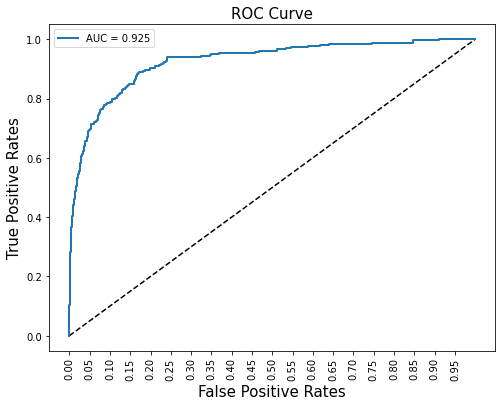

Best Threshold=0.020694


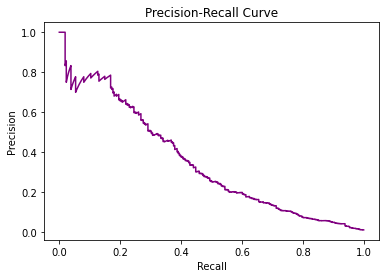

In [36]:
from xgboost import XGBClassifier
model_1 = XGBClassifier( n_estimators=600, learning_rate=0.013185216741789522,
                       subsample=0.9, colsample_bytree=0.8,
                       reg_alpha=6, reg_lambda=5, max_depth=5,
                       min_child_weight=184, scale_pos_weight=45,random_state=42)
model_1.fit(X_train, y_train, eval_metric='auc')
model_evaluation(model_1,X_test,y_test)
plot_roc_curve(model_1,X_test,y_test)
prec_recall_curve(model_1,X_test,y_test)

[[19103  3136]
 [   40   221]]

Accuracy: 0.8588444444444444
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     22239
           1       0.07      0.85      0.12       261

    accuracy                           0.86     22500
   macro avg       0.53      0.85      0.52     22500
weighted avg       0.99      0.86      0.91     22500

ROC-AUC score: 0.9287637833435756
Best Threshold=0.406235


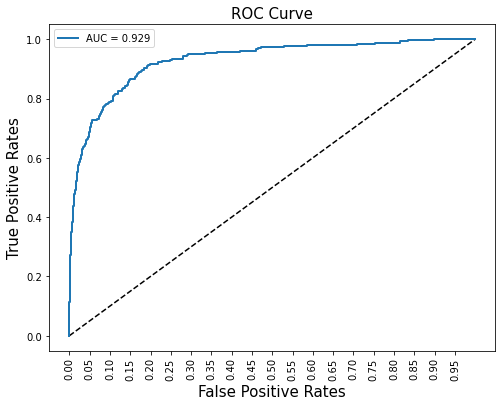

Best Threshold=0.021725


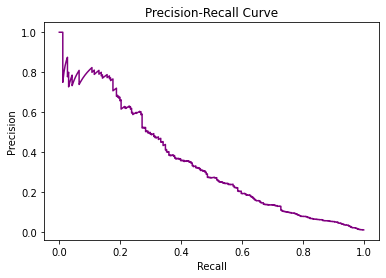

In [37]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

model_2 =  BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42,
        learning_rate=0.1,max_bins=255,scoring='roc_auc'),
        n_estimators=100,n_jobs=2,
        random_state=42)

model_2.fit(X_train, y_train)
model_evaluation(model_2,X_test,y_test)
plot_roc_curve(model_2,X_test,y_test)
prec_recall_curve(model_2,X_test,y_test)

[[18564  3675]
 [   31   230]]

Accuracy: 0.8352888888888889
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22239
           1       0.06      0.88      0.11       261

    accuracy                           0.84     22500
   macro avg       0.53      0.86      0.51     22500
weighted avg       0.99      0.84      0.90     22500

ROC-AUC score: 0.9299882037337672
Best Threshold=0.489000


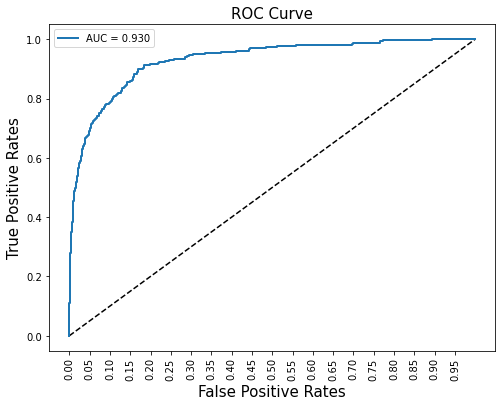

Best Threshold=0.026191


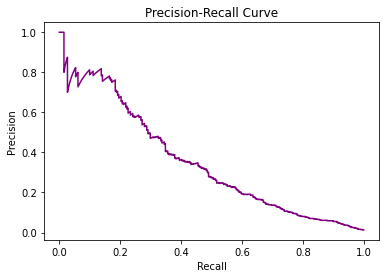

In [38]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier 
from imblearn.ensemble import EasyEnsembleClassifier 

model_3 = EasyEnsembleClassifier( 
        base_estimator=HistGradientBoostingClassifier(random_state=42,
        learning_rate=0.1,max_bins=255,scoring='roc_auc'),
        n_estimators=600,
        random_state=42 )

model_3.fit(X_train, y_train)
model_evaluation(model_3,X_test,y_test)
plot_roc_curve(model_3,X_test,y_test)
prec_recall_curve(model_3,X_test,y_test)

[[18541  3698]
 [   31   230]]

Accuracy: 0.8342666666666667
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22239
           1       0.06      0.88      0.11       261

    accuracy                           0.83     22500
   macro avg       0.53      0.86      0.51     22500
weighted avg       0.99      0.83      0.90     22500

ROC-AUC score: 0.9243204139495371
Best Threshold=0.498211


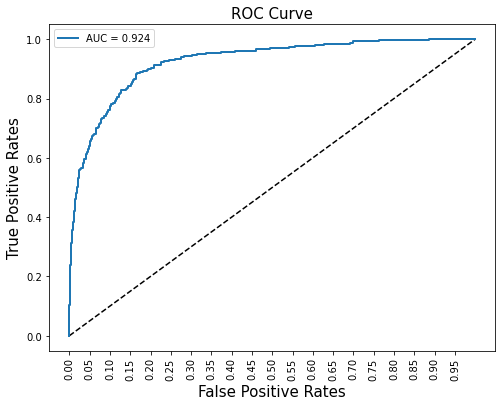

Best Threshold=0.023277


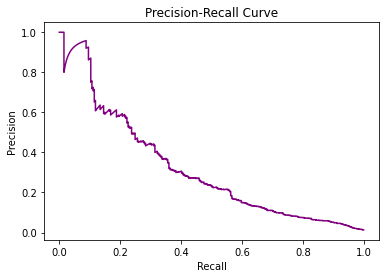

In [39]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

model_4 = HistGradientBoostingClassifier(random_state=42,max_iter=100,
        learning_rate=0.1,max_bins=255,scoring='roc_auc')

model_4.fit(X_under, y_under)
model_evaluation(model_4,X_test,y_test)
plot_roc_curve(model_4,X_test,y_test)
prec_recall_curve(model_4,X_test,y_test)

[11:37:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[18475  3764]
 [   45   216]]

Accuracy: 0.8307111111111111
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22239
           1       0.05      0.83      0.10       261

    accuracy                           0.83     22500
   macro avg       0.53      0.83      0.50     22500
weighted avg       0.99      0.83      0.90     22500

ROC-AUC score: 0.9123794293928773
Best Threshold=0.400790


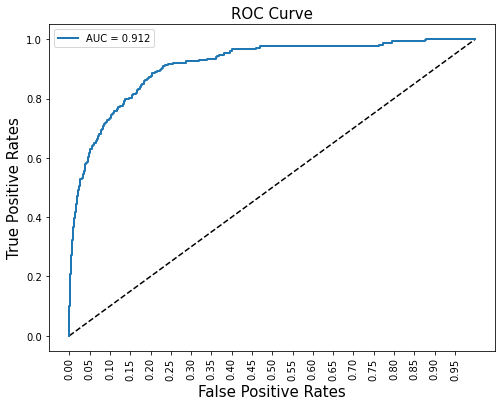

Best Threshold=0.007859


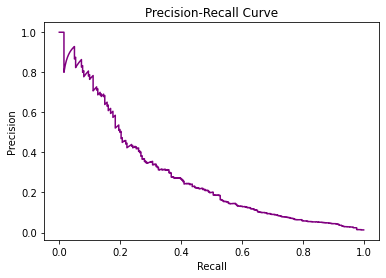

In [40]:
from xgboost import XGBClassifier
model_5 = XGBClassifier(random_state=42)
model_5.fit(X_under,y_under)

model_evaluation(model_5,X_test,y_test)
plot_roc_curve(model_5,X_test,y_test)
prec_recall_curve(model_5,X_test,y_test)

[[18507  3732]
 [   33   228]]

Accuracy: 0.8326666666666667
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22239
           1       0.06      0.87      0.11       261

    accuracy                           0.83     22500
   macro avg       0.53      0.85      0.51     22500
weighted avg       0.99      0.83      0.90     22500

ROC-AUC score: 0.9231218361171798
Best Threshold=0.475596


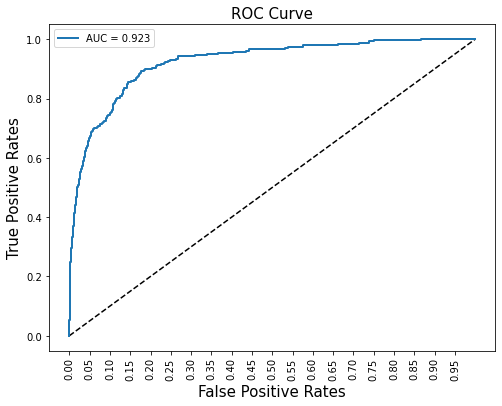

Best Threshold=0.027172


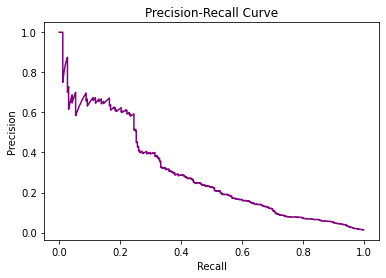

In [41]:
import lightgbm as lgb
model_6 = lgb.LGBMClassifier()
model_6.fit(X_under, y_under)

model_evaluation(model_6,X_test,y_test)
plot_roc_curve(model_6,X_test,y_test)
prec_recall_curve(model_6,X_test,y_test)

[[17836  4403]
 [   39   222]]

Accuracy: 0.8025777777777777
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     22239
           1       0.05      0.85      0.09       261

    accuracy                           0.80     22500
   macro avg       0.52      0.83      0.49     22500
weighted avg       0.99      0.80      0.88     22500

ROC-AUC score: 0.9003693590649404
Best Threshold=0.530000


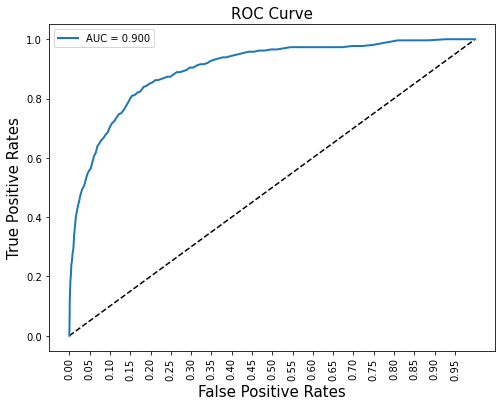

Best Threshold=0.020000


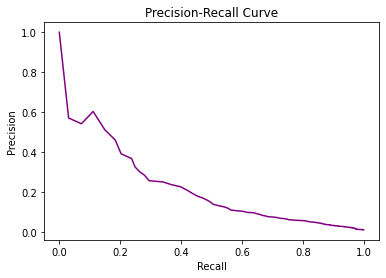

In [42]:
from imblearn.ensemble import BalancedRandomForestClassifier
model_7 = BalancedRandomForestClassifier(random_state=42,criterion='entropy')
model_7.fit(X_train, y_train)
model_evaluation(model_7,X_test,y_test)
plot_roc_curve(model_7,X_test,y_test)
prec_recall_curve(model_7,X_test,y_test)

[[18597  3642]
 [   37   224]]

Accuracy: 0.8364888888888888
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     22239
           1       0.06      0.86      0.11       261

    accuracy                           0.84     22500
   macro avg       0.53      0.85      0.51     22500
weighted avg       0.99      0.84      0.90     22500

ROC-AUC score: 0.9211007758108146
Best Threshold=0.462089


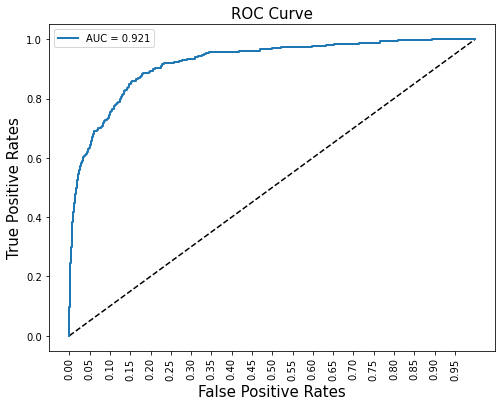

Best Threshold=0.029317


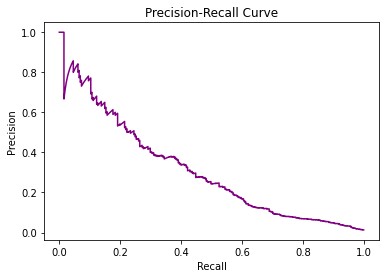

In [43]:
from catboost import CatBoostClassifier
model_8 = CatBoostClassifier(verbose=False,random_state=42)
model_8.fit(X_under, y_under)

model_evaluation(model_8,X_test,y_test)
plot_roc_curve(model_8,X_test,y_test)
prec_recall_curve(model_8,X_test,y_test)

In [44]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          150, activation='relu', kernel_initializer='he_uniform',
          input_shape=(X_train_.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          50, activation='relu', kernel_initializer='he_uniform'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

2022-02-23 11:38:12.252514: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [45]:
model_9 = make_model()
weights = {0:1,1:100}
model_9.fit(X_train_, y_train.values,epochs = 100,class_weight = weights,batch_size=1000)
y_pred_ = model_9.predict(X_test_).flatten()
print(f"ROC score: {roc_auc_score(y_test,y_pred_)}")

2022-02-23 11:38:14.044071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
428/428 [==============================] - 7s 10ms/step - loss: 1.5847 - tp: 3813.0000 - fp: 217677.0000 - tn: 204866.0000 - fn: 1143.0000 - accuracy: 0.4881 - precision: 0.0172 - recall: 0.7694 - auc: 0.7063 - prc: 0.0514
Epoch 2/100
428/428 [==============================] - 5s 11ms/step - loss: 1.1817 - tp: 3984.0000 - fp: 161641.0000 - tn: 260902.0000 - fn: 972.0000 - accuracy: 0.6196 - precision: 0.0241 - recall: 0.8039 - auc: 0.8021 - prc: 0.1365
Epoch 3/100
428/428 [==============================] - 4s 10ms/step - loss: 1.0519 - tp: 4017.0000 - fp: 124951.0000 - tn: 297592.0000 - fn: 939.0000 - accuracy: 0.7055 - precision: 0.0311 - recall: 0.8105 - auc: 0.8449 - prc: 0.1803
Epoch 4/100
428/428 [==============================] - 5s 11ms/step - loss: 0.9804 - tp: 4163.0000 - fp: 113419.0000 - tn: 309124.0000 - fn: 793.0000 - accuracy: 0.7328 - precision: 0.0354 - recall: 0.8400 - auc: 0.8702 - prc: 0.1870
Epoch 5/100
428/428 [==============================] - 5s 12ms/

[11:46:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

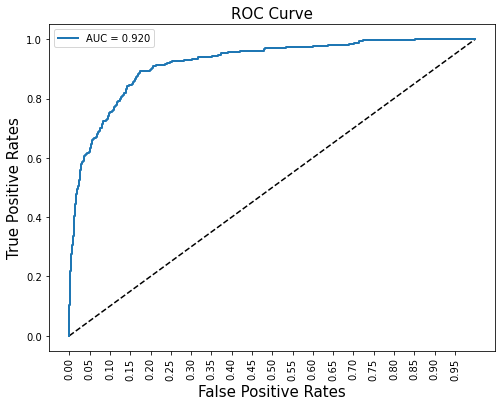

Best Threshold=0.037970


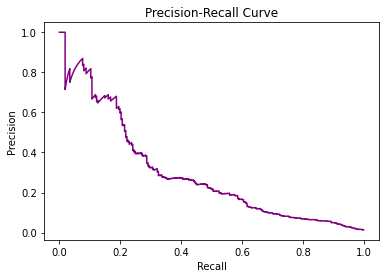

In [46]:
from mlxtend.classifier import StackingCVClassifier
model = StackingCVClassifier(classifiers=(model_4,model_5,model_6,model_8),
        meta_classifier=model_8,use_features_in_secondary=True,cv=3,
        random_state=42)
model.fit(X_under,y_under)

model_evaluation(model,X_test,y_test)
plot_roc_curve(model,X_test,y_test)
prec_recall_curve(model,X_test,y_test)

In [47]:
best_model = model_3

In [48]:
final_pred = best_model.predict_proba(test_dataset)[:,1]
my_submission = pd.DataFrame({'order_id':id, 'cancelled': final_pred})
my_submission.to_csv('submission4.csv',index=False)